# KPI Stats

In [1]:
import pandas as pd

allsvenskan = pd.read_csv('csv/allsvenskan_all.csv')
damallsvenskan = pd.read_csv('csv/damallsvenskan_all.csv')
allsvenskan_2022 = pd.read_csv('csv/allsvenskan2022.csv')
damallsvenskan_2022 = pd.read_csv('csv/damallsvenskan2022.csv')

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_7929/3195218286.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
damallsvenskan_factor = 264 + 264 + 264 + 264 + 364
allsvenskan_factor = 480 + 480 + 480 + 480 + 480

## Ball Possession

In [3]:
def calculate_possession_times(df):
    possessions = []
    current_team = None
    start_time = 0

    for index, row in df.iterrows():
        if current_team is None:
            current_team = row["team"]
            start_time = row["start_time"]
        else:
            if current_team != row["team"] and (row["action"] == "Pass accurate"):
                time_of_possession = row["start_time"] - start_time
                if time_of_possession > 0:
                    possessions.append(time_of_possession)
                current_team = row["team"]
                start_time = row["start_time"]

    return possessions

possession_times_damallsvenskan = calculate_possession_times(damallsvenskan)
possession_times_allsvenskan = calculate_possession_times(allsvenskan)

## Pass Length

In [4]:
damallsvenskan_passes_acc = damallsvenskan[damallsvenskan["action"] == "Pass accurate"]
allsvenskan_passes_acc = allsvenskan[allsvenskan["action"] == "Pass accurate"]

def calculate_pass_lenth(df):
    pass_lengths = []
    for index, row in df.iterrows():
        pass_lengths.append(((row["xpos"] - row["xdest"])**2 + (row["ypos"] - row["ydest"])**2)**0.5)

    return pass_lengths

pass_length_damallsvenskan = calculate_pass_lenth(damallsvenskan_passes_acc)
pass_length_allsvenskan = calculate_pass_lenth(allsvenskan_passes_acc)

## Passing Chains

In [5]:
def calculate_passing_chains(df):
    chains = []
    current_team = None
    current_chain = 0

    for index, row in df.iterrows():
        if current_team is None:
            current_team = row["team"]
            current_chain = 1
        else:
            if current_team != row["team"] and (row["action"] == "Pass accurate"):
                chains.append(current_chain)
                current_team = row["team"]
                current_chain = 1
            else:
                current_chain += 1

    if current_chain > 0:
        chains.append(current_chain)
    
    return chains

passing_chains_damallsvenskan = calculate_passing_chains(damallsvenskan)
passing_chains_allsvenskan = calculate_passing_chains(allsvenskan)

## Fouls

In [6]:
def count_fouls(df):
    fouls = []
    for team in df['team'].unique():
        team_fouls_count = df[(df['team'] == team) & (df['action'] == 'Foul')].shape[0]
        fouls.append((team, team_fouls_count))
    return fouls

fouls_damallsvenskan = count_fouls(damallsvenskan_2022)
fouls_allsvenskan = count_fouls(allsvenskan_2022)

## Cards

In [7]:
def count_yellow_cards(df):
    cards = []
    for team in df['team'].unique():
        team_cards_count = df[(df['team'] == team) & (df['action'] == 'Yellow card')].shape[0]
        cards.append((team, team_cards_count))
    return cards

def count_red_cards(df):
    cards = []
    for team in df['team'].unique():
        team_cards_count = df[(df['team'] == team) & (df['action'] == 'Red card')].shape[0]
        cards.append((team, team_cards_count))
    return cards

yellow_cards_allsvenskan = count_yellow_cards(allsvenskan_2022)
red_cards_allsvenskan = count_red_cards(allsvenskan_2022)
yellow_cards_damallsvenskan = count_yellow_cards(damallsvenskan_2022)
red_cards_damallsvenskan = count_red_cards(damallsvenskan_2022)

## Statistics

### Passing length

In [8]:
# Calculate mean, median, and standard deviation for Damallsvenskan
mean_damallsvenskan = round(sum(pass_length_damallsvenskan) / len(pass_length_damallsvenskan), 1)
median_damallsvenskan = round(sorted(pass_length_damallsvenskan)[len(pass_length_damallsvenskan) // 2], 1)
std_damallsvenskan = round(pd.Series(pass_length_damallsvenskan).std(), 1)

# Calculate mean, median, and standard deviation for Allsvenskan
mean_allsvenskan = round(sum(pass_length_allsvenskan) / len(pass_length_allsvenskan), 1)
median_allsvenskan = round(sorted(pass_length_allsvenskan)[len(pass_length_allsvenskan) // 2], 1)
std_allsvenskan = round(pd.Series(pass_length_allsvenskan).std(), 1)

# Print the rounded values
print("Mean passing length in Damallsvenskan: ", mean_damallsvenskan)
print("Median passing length in Damallsvenskan: ", median_damallsvenskan)
print("Standard deviation of passing length in Damallsvenskan: ", std_damallsvenskan)
print('\n')
print("Mean passing length in Allsvenskan: ", mean_allsvenskan)
print("Median passing length in Allsvenskan: ", median_allsvenskan)
print("Standard deviation of passing length in Allsvenskan: ", std_allsvenskan)

Mean passing length in Damallsvenskan:  22.6
Median passing length in Damallsvenskan:  20.1
Standard deviation of passing length in Damallsvenskan:  12.3


Mean passing length in Allsvenskan:  23.6
Median passing length in Allsvenskan:  20.6
Standard deviation of passing length in Allsvenskan:  13.7


In [9]:
from scipy.stats import ttest_ind
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

pass_length_allsvenskan = pass_length_allsvenskan[:len(pass_length_damallsvenskan)]

#Before applying T-tests, checks for normality (using Shapiro-Wilk test) and ho-
#mogeneity of variances (using Levene’s test) are conducted to ensure the assump-
#tions underlying these tests are met.

from scipy.stats import shapiro, levene

# Shapiro-Wilk test for normality

shapiro_test_damallsvenskan = shapiro(pass_length_damallsvenskan)
shapiro_test_allsvenskan = shapiro(pass_length_allsvenskan)

print("Shapiro-Wilk test for normality in Damallsvenskan: ", shapiro_test_damallsvenskan)
print("Shapiro-Wilk test for normality in Allsvenskan: ", shapiro_test_allsvenskan)

# Levene's test for homogeneity of variances

levene_test = levene(pass_length_allsvenskan, pass_length_damallsvenskan)
print("Levene's test for homogeneity of variances: ", levene_test)

# T-test for independent samples

t_test = ttest_ind(pass_length_allsvenskan, pass_length_damallsvenskan)
print("T-test for independent samples: ", t_test)

Shapiro-Wilk test for normality in Damallsvenskan:  ShapiroResult(statistic=0.9332875314435589, pvalue=1.8392664105188027e-131)
Shapiro-Wilk test for normality in Allsvenskan:  ShapiroResult(statistic=0.9170338414783243, pvalue=4.1661064111651255e-138)
Levene's test for homogeneity of variances:  LeveneResult(statistic=1945.244984206076, pvalue=0.0)
T-test for independent samples:  TtestResult(statistic=34.14629687254814, pvalue=2.135089490593134e-255, df=996434.0)


/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_7929/2545004644.py:15: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 498218.
  shapiro_test_damallsvenskan = shapiro(pass_length_damallsvenskan)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_7929/2545004644.py:16: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 498218.
  shapiro_test_allsvenskan = shapiro(pass_length_allsvenskan)


In [10]:
import numpy as np
def cohens_d(group1, group2):
    # Convert lists to NumPy arrays for statistical calculation
    group1 = np.array(group1)
    group2 = np.array(group2)
    
    # Calculate the size, means, and variances of the two groups
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)  # ddof=1 for sample variance
    
    # Calculate the pooled standard deviation (s)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Calculate Cohen's d
    d = (mean1 - mean2) / pooled_std
    return d

# Assuming pass_length_allsvenskan and pass_length_damallsvenskan are your lists
d = cohens_d(pass_length_allsvenskan, pass_length_damallsvenskan)
print(f"Cohen's d: {d}")

Cohen's d: 0.06841461741346086


### Ball Possession

In [11]:
# Calculate mean median std for possession times
mean_possession_times_damallsvenskan = round(sum(possession_times_damallsvenskan) / len(possession_times_damallsvenskan), 1)
median_possession_times_damallsvenskan = round(sorted(possession_times_damallsvenskan)[len(possession_times_damallsvenskan) // 2], 1)
std_possession_times_damallsvenskan = round(pd.Series(possession_times_damallsvenskan).std(), 1)

mean_possession_times_allsvenskan = round(sum(possession_times_allsvenskan) / len(possession_times_allsvenskan), 1)
median_possession_times_allsvenskan = round(sorted(possession_times_allsvenskan)[len(possession_times_allsvenskan) // 2], 1)
std_possession_times_allsvenskan = round(pd.Series(possession_times_allsvenskan).std(), 1)

print("Mean possession times in Damallsvenskan: ", mean_possession_times_damallsvenskan)
print("Median possession times in Damallsvenskan: ", median_possession_times_damallsvenskan)
print("Standard deviation of possession times in Damallsvenskan: ", std_possession_times_damallsvenskan)
print('\n')
print("Mean possession times in Allsvenskan: ", mean_possession_times_allsvenskan)
print("Median possession times in Allsvenskan: ", median_possession_times_allsvenskan)
print("Standard deviation of possession times in Allsvenskan: ", std_possession_times_allsvenskan)

Mean possession times in Damallsvenskan:  35.6
Median possession times in Damallsvenskan:  23
Standard deviation of possession times in Damallsvenskan:  38.4


Mean possession times in Allsvenskan:  42.4
Median possession times in Allsvenskan:  27
Standard deviation of possession times in Allsvenskan:  46.2


In [12]:
possession_times_allsvenskan = possession_times_allsvenskan[:len(possession_times_damallsvenskan)]

# Shapiro-Wilk test for normality
shapiro_test_possession_times_damallsvenskan = shapiro(possession_times_damallsvenskan)
shapiro_test_possession_times_allsvenskan = shapiro(possession_times_allsvenskan)

print("Shapiro-Wilk test for normality in possession times in Damallsvenskan: ", shapiro_test_possession_times_damallsvenskan)
print("Shapiro-Wilk test for normality in possession times in Allsvenskan: ", shapiro_test_possession_times_allsvenskan)

# Levene's test for homogeneity of variances
levene_test_possession_times = levene(possession_times_allsvenskan, possession_times_damallsvenskan)
print("Levene's test for homogeneity of variances in possession times: ", levene_test_possession_times)

# T-test for independent samples
t_test_possession_times = ttest_ind(possession_times_allsvenskan, possession_times_damallsvenskan)
print("T-test for independent samples in possession times: ", t_test_possession_times)

Shapiro-Wilk test for normality in possession times in Damallsvenskan:  ShapiroResult(statistic=0.7444051301150922, pvalue=1.4693729861163686e-141)
Shapiro-Wilk test for normality in possession times in Allsvenskan:  ShapiroResult(statistic=0.7584090266963694, pvalue=7.971374245951551e-140)
Levene's test for homogeneity of variances in possession times:  LeveneResult(statistic=1480.5114911494732, pvalue=8.4e-323)
T-test for independent samples in possession times:  TtestResult(statistic=36.15249536987596, pvalue=2.4172082089617685e-285, df=217172.0)


/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_7929/1763721547.py:4: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 108587.
  shapiro_test_possession_times_damallsvenskan = shapiro(possession_times_damallsvenskan)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_7929/1763721547.py:5: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 108587.
  shapiro_test_possession_times_allsvenskan = shapiro(possession_times_allsvenskan)


In [13]:
# cohens_d function
d_possession_times = cohens_d(possession_times_allsvenskan, possession_times_damallsvenskan)
print(f"Cohen's d in possession times: {d_possession_times}")

Cohen's d in possession times: 0.15515449411120485


### Passing Chains

In [14]:
# Calculate mean median std for possession times
mean_passing_chains_damallsvenskan = round(sum(passing_chains_damallsvenskan) / len(passing_chains_damallsvenskan), 1)
median_passing_chains_damallsvenskan = round(sorted(passing_chains_damallsvenskan)[len(passing_chains_damallsvenskan) // 2], 1)
std_passing_chains_damallsvenskan = round(pd.Series(passing_chains_damallsvenskan).std(), 1)

mean_passing_chains_allsvenskan = round(sum(passing_chains_allsvenskan) / len(passing_chains_allsvenskan), 1)
median_passing_chains_allsvenskan = round(sorted(passing_chains_allsvenskan)[len(passing_chains_allsvenskan) // 2], 1)
std_passing_chains_allsvenskan = round(pd.Series(passing_chains_allsvenskan).std(), 1)

print("Mean passing chains in Damallsvenskan: ", mean_passing_chains_damallsvenskan)
print("Median passing chains in Damallsvenskan: ", median_passing_chains_damallsvenskan)
print("Standard deviation of passing chains in Damallsvenskan: ", std_passing_chains_damallsvenskan)
print('\n')
print("Mean passing chains in Allsvenskan: ", mean_passing_chains_allsvenskan)
print("Median passing chains in Allsvenskan: ", median_passing_chains_allsvenskan)
print("Standard deviation of passing chains in Allsvenskan: ", std_passing_chains_allsvenskan)

Mean passing chains in Damallsvenskan:  16.8
Median passing chains in Damallsvenskan:  12
Standard deviation of passing chains in Damallsvenskan:  15.7


Mean passing chains in Allsvenskan:  18.8
Median passing chains in Allsvenskan:  13
Standard deviation of passing chains in Allsvenskan:  17.7


In [15]:
passing_chains_allsvenskan = passing_chains_allsvenskan[:len(passing_chains_damallsvenskan)]

# Shapiro-Wilk test for normality
shapiro_test_passing_chains_damallsvenskan = shapiro(passing_chains_damallsvenskan)
shapiro_test_passing_chains_allsvenskan = shapiro(passing_chains_allsvenskan)
print("Shapiro-Wilk test for normality in passing chains in Damallsvenskan: ", shapiro_test_passing_chains_damallsvenskan)
print("Shapiro-Wilk test for normality in passing chains in Allsvenskan: ", shapiro_test_passing_chains_allsvenskan)

# Levene's test for homogeneity of variances
levene_test_passing_chains = levene(passing_chains_allsvenskan, passing_chains_damallsvenskan)
print("Levene's test for homogeneity of variances in passing chains: ", levene_test_passing_chains)

# T-test for independent samples
t_test_passing_chains = ttest_ind(passing_chains_allsvenskan, passing_chains_damallsvenskan)
print("T-test for independent samples in passing chains: ", t_test_passing_chains)

Shapiro-Wilk test for normality in passing chains in Damallsvenskan:  ShapiroResult(statistic=0.7917191174147011, pvalue=1.5335190641499047e-135)
Shapiro-Wilk test for normality in passing chains in Allsvenskan:  ShapiroResult(statistic=0.7969095775318107, pvalue=8.849738976402902e-135)
Levene's test for homogeneity of variances in passing chains:  LeveneResult(statistic=692.2774857639689, pvalue=2.4689502250306863e-152)
T-test for independent samples in passing chains:  TtestResult(statistic=27.640319995432748, pvalue=7.098860986826089e-168, df=219276.0)


/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_7929/1431227644.py:4: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 109639.
  shapiro_test_passing_chains_damallsvenskan = shapiro(passing_chains_damallsvenskan)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_7929/1431227644.py:5: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 109639.
  shapiro_test_passing_chains_allsvenskan = shapiro(passing_chains_allsvenskan)


In [16]:
# cohens_d function
d_passing_chains = cohens_d(passing_chains_allsvenskan, passing_chains_damallsvenskan)
print(f"Cohen's d in passing chains: {d_passing_chains}")

Cohen's d in passing chains: 0.118052593234448


### Fouls

In [17]:
# Calculate mean median std for fouls
mean_fouls_damallsvenskan = round(sum([foul[1] for foul in fouls_damallsvenskan]) / len(fouls_damallsvenskan), 1)
median_fouls_damallsvenskan = round(sorted([foul[1] for foul in fouls_damallsvenskan])[len(fouls_damallsvenskan) // 2], 1)
std_fouls_damallsvenskan = round(pd.Series([foul[1] for foul in fouls_damallsvenskan]).std(), 1)

mean_fouls_allsvenskan = round(sum([foul[1] for foul in fouls_allsvenskan]) / len(fouls_allsvenskan), 1)
median_fouls_allsvenskan = round(sorted([foul[1] for foul in fouls_allsvenskan])[len(fouls_allsvenskan) // 2], 1)
std_fouls_allsvenskan = round(pd.Series([foul[1] for foul in fouls_allsvenskan]).std(), 1)

print("Mean fouls in Damallsvenskan: ", mean_fouls_damallsvenskan)
print("Median fouls in Damallsvenskan: ", median_fouls_damallsvenskan)
print("Standard deviation of fouls in Damallsvenskan: ", std_fouls_damallsvenskan)
print('\n')
print("Mean fouls in Allsvenskan: ", mean_fouls_allsvenskan)
print("Median fouls in Allsvenskan: ", median_fouls_allsvenskan)
print("Standard deviation of fouls in Allsvenskan: ", std_fouls_allsvenskan)

Mean fouls in Damallsvenskan:  206.1
Median fouls in Damallsvenskan:  212
Standard deviation of fouls in Damallsvenskan:  31.7


Mean fouls in Allsvenskan:  323.3
Median fouls in Allsvenskan:  314
Standard deviation of fouls in Allsvenskan:  51.5


### Cards

In [18]:
# Calculate mean median std for yellow cards and red cards
mean_yellow_cards_damallsvenskan = round(sum([card[1] for card in yellow_cards_damallsvenskan]) / len(yellow_cards_damallsvenskan), 1)
median_yellow_cards_damallsvenskan = round(sorted([card[1] for card in yellow_cards_damallsvenskan])[len(yellow_cards_damallsvenskan) // 2], 1)
std_yellow_cards_damallsvenskan = round(pd.Series([card[1] for card in yellow_cards_damallsvenskan]).std(), 1)

mean_red_cards_damallsvenskan = round(sum([card[1] for card in red_cards_damallsvenskan]) / len(red_cards_damallsvenskan), 1)
median_red_cards_damallsvenskan = round(sorted([card[1] for card in red_cards_damallsvenskan])[len(red_cards_damallsvenskan) // 2], 1)
std_red_cards_damallsvenskan = round(pd.Series([card[1] for card in red_cards_damallsvenskan]).std(), 1)

mean_yellow_cards_allsvenskan = round(sum([card[1] for card in yellow_cards_allsvenskan]) / len(yellow_cards_allsvenskan), 1)
median_yellow_cards_allsvenskan = round(sorted([card[1] for card in yellow_cards_allsvenskan])[len(yellow_cards_allsvenskan) // 2], 1)
std_yellow_cards_allsvenskan = round(pd.Series([card[1] for card in yellow_cards_allsvenskan]).std(), 1)

mean_red_cards_allsvenskan = round(sum([card[1] for card in red_cards_allsvenskan]) / len(red_cards_allsvenskan), 1)
median_red_cards_allsvenskan = round(sorted([card[1] for card in red_cards_allsvenskan])[len(red_cards_allsvenskan) // 2], 1)
std_red_cards_allsvenskan = round(pd.Series([card[1] for card in red_cards_allsvenskan]).std(), 1)

print("Mean yellow cards in Damallsvenskan: ", mean_yellow_cards_damallsvenskan)
print("Median yellow cards in Damallsvenskan: ", median_yellow_cards_damallsvenskan)
print("Standard deviation of yellow cards in Damallsvenskan: ", std_yellow_cards_damallsvenskan)
print('\n')
print("Mean red cards in Damallsvenskan: ", mean_red_cards_damallsvenskan)
print("Median red cards in Damallsvenskan: ", median_red_cards_damallsvenskan)
print("Standard deviation of red cards in Damallsvenskan: ", std_red_cards_damallsvenskan)
print('\n')
print("Mean yellow cards in Allsvenskan: ", mean_yellow_cards_allsvenskan)
print("Median yellow cards in Allsvenskan: ", median_yellow_cards_allsvenskan)
print("Standard deviation of yellow cards in Allsvenskan: ", std_yellow_cards_allsvenskan)
print('\n')
print("Mean red cards in Allsvenskan: ", mean_red_cards_allsvenskan)
print("Median red cards in Allsvenskan: ", median_red_cards_allsvenskan)
print("Standard deviation of red cards in Allsvenskan: ", std_red_cards_allsvenskan)


Mean yellow cards in Damallsvenskan:  20.6
Median yellow cards in Damallsvenskan:  20
Standard deviation of yellow cards in Damallsvenskan:  6.6


Mean red cards in Damallsvenskan:  0.6
Median red cards in Damallsvenskan:  0
Standard deviation of red cards in Damallsvenskan:  0.8


Mean yellow cards in Allsvenskan:  55.9
Median yellow cards in Allsvenskan:  58
Standard deviation of yellow cards in Allsvenskan:  13.3


Mean red cards in Allsvenskan:  1.4
Median red cards in Allsvenskan:  1
Standard deviation of red cards in Allsvenskan:  1.2


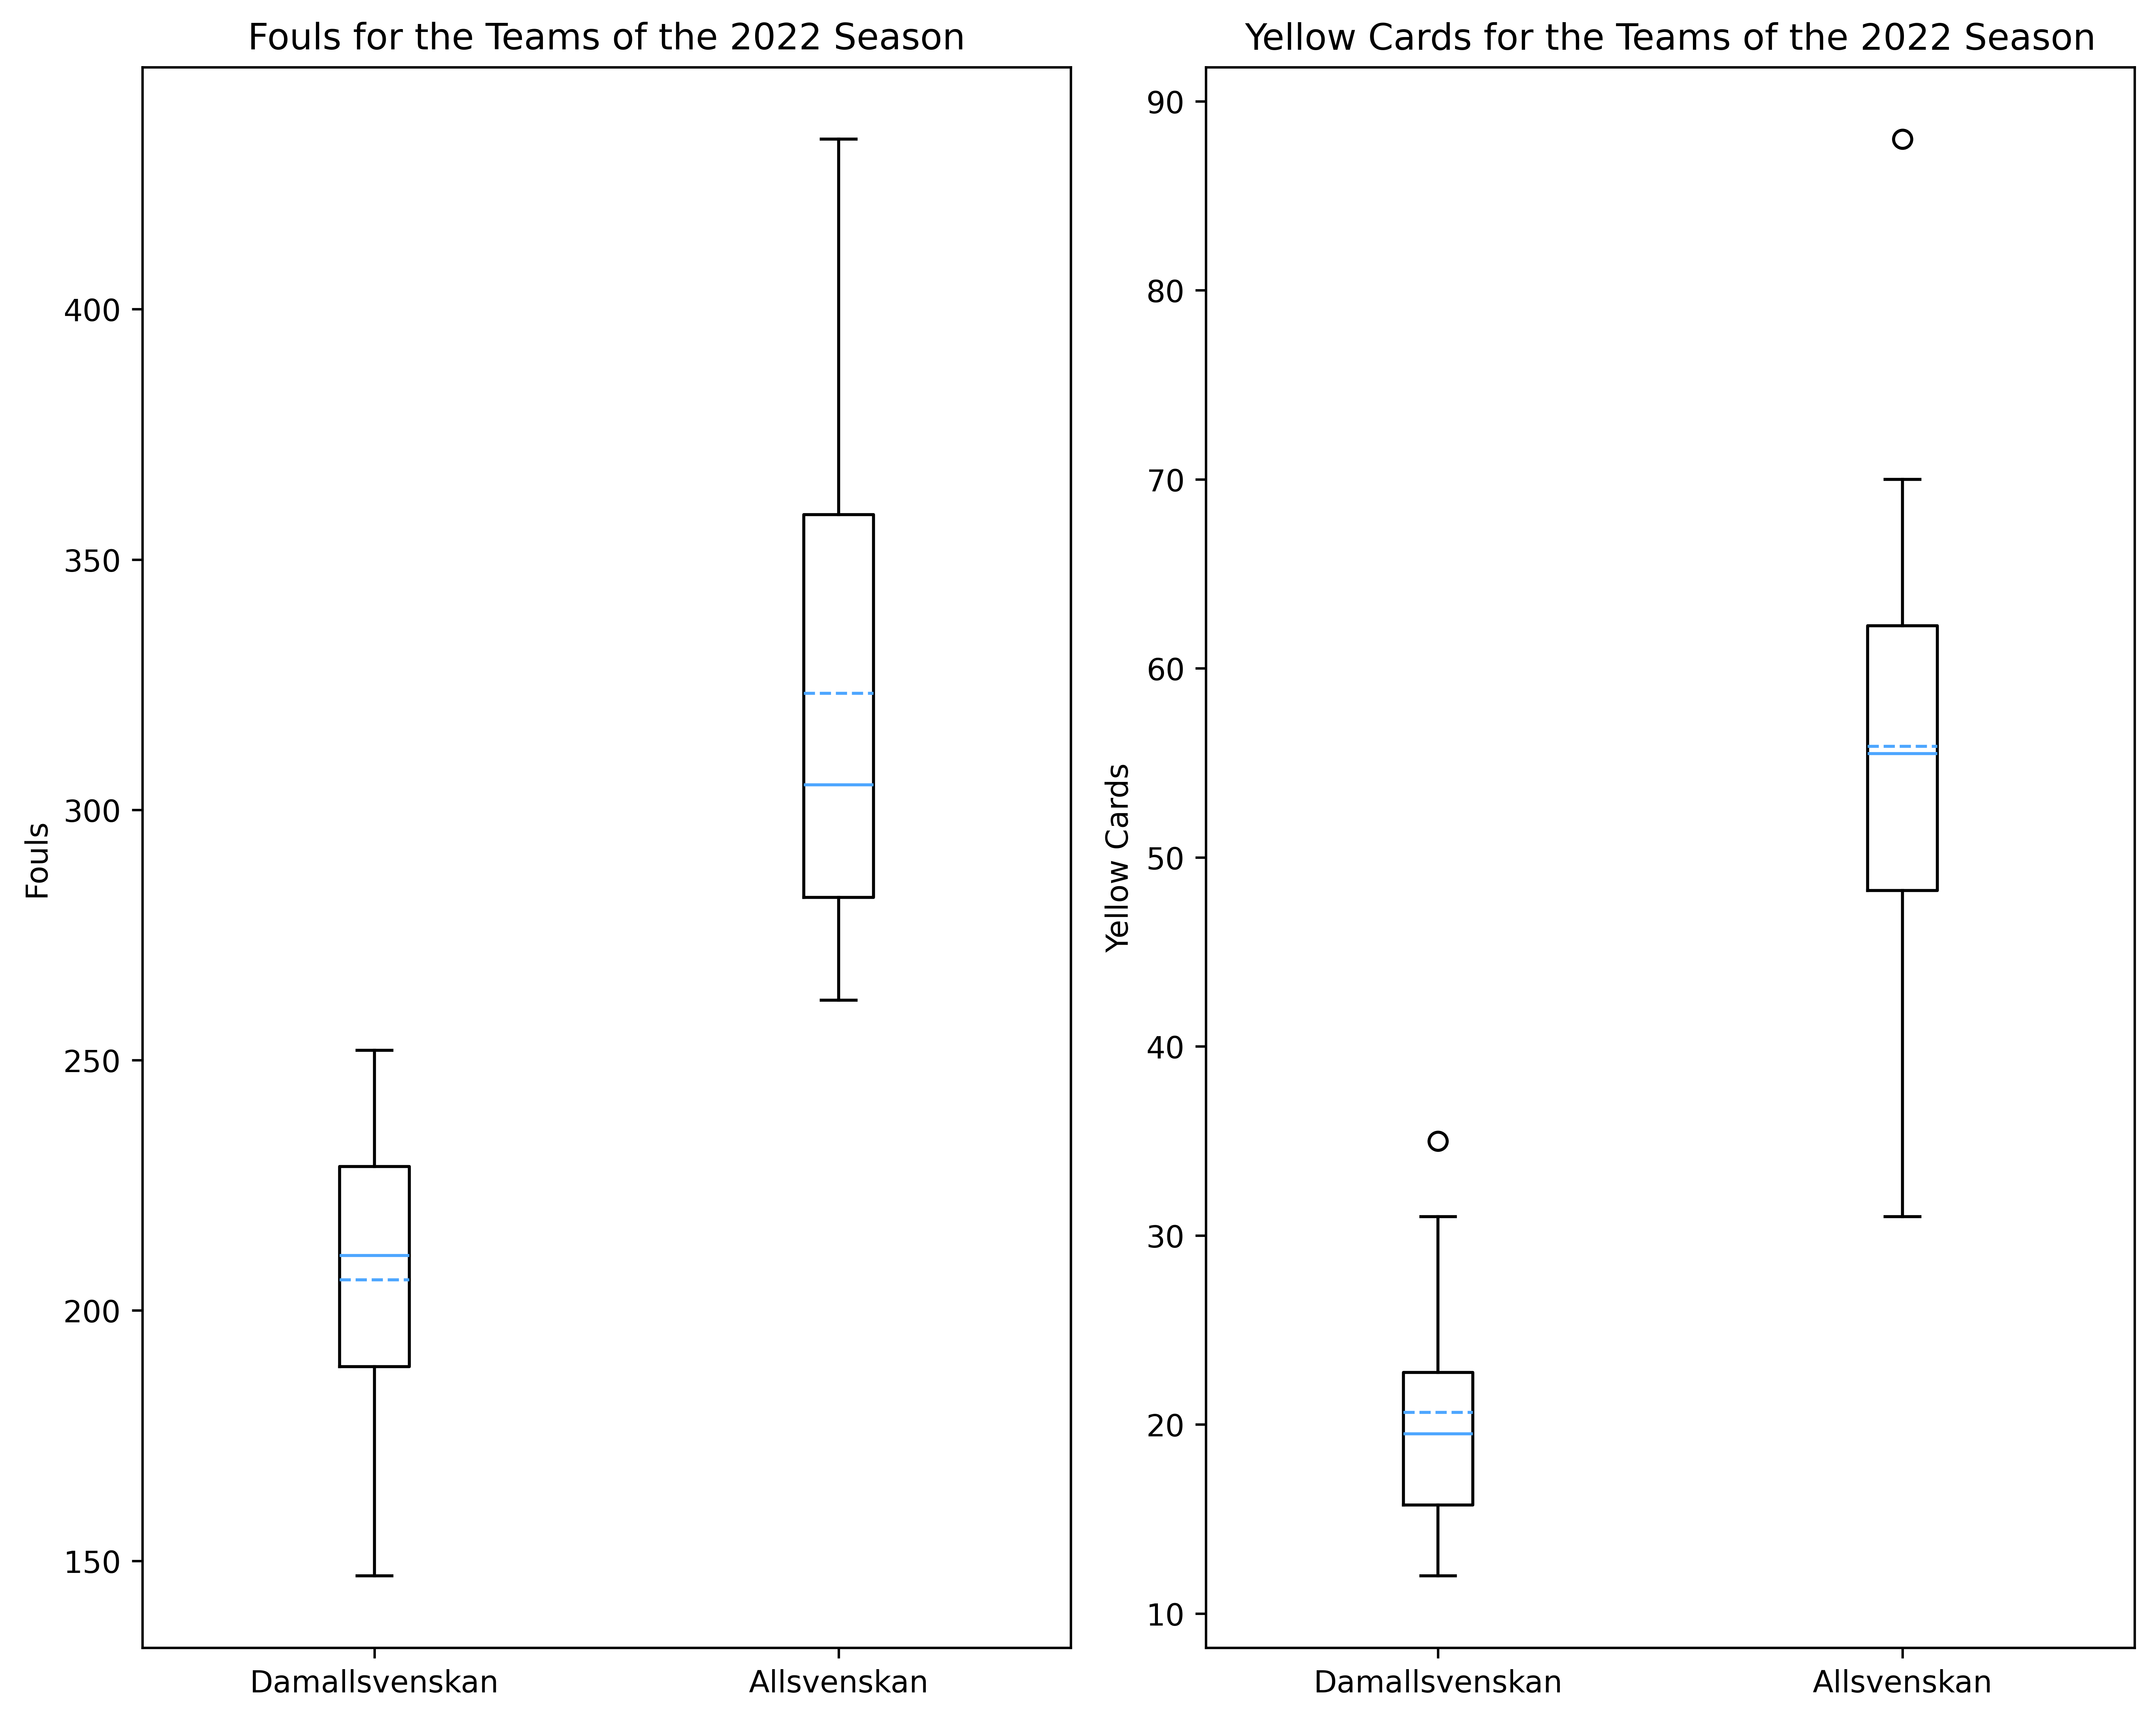

Team with the most yellow cards in Allsvenskan:  Varberg
Team with the most yellow cards in Damallsvenskan:  AIK


In [37]:
import matplotlib.pyplot as plt

# Data preparation
fouls_damallsvenskan_1 = [foul[1] for foul in fouls_damallsvenskan]
fouls_allsvenskan_1 = [foul[1] for foul in fouls_allsvenskan]
yellow_cards_damallsvenskan_1 = [card[1] for card in yellow_cards_damallsvenskan]
yellow_cards_allsvenskan_1 = [card[1] for card in yellow_cards_allsvenskan]

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), dpi=300)  # 1 row, 2 columns for subplots

# Box plot for fouls
axes[0].boxplot([fouls_damallsvenskan_1, fouls_allsvenskan_1], showmeans=True, meanline=True, meanprops={'color': '#4da6ff'}, medianprops={'color': '#4da6ff'})
axes[0].set_xticklabels(['Damallsvenskan', 'Allsvenskan'])
axes[0].set_ylabel('Fouls')
axes[0].set_title('Fouls for the Teams of the 2022 Season')

# Box plot for yellow cards
axes[1].boxplot([yellow_cards_damallsvenskan_1, yellow_cards_allsvenskan_1], showmeans=True, meanline=True, meanprops={'color': '#4da6ff'}, medianprops={'color': '#4da6ff'})
axes[1].set_xticklabels(['Damallsvenskan', 'Allsvenskan'])
axes[1].set_ylabel('Yellow Cards')
axes[1].set_title('Yellow Cards for the Teams of the 2022 Season')

# Display the plot
plt.tight_layout()  # Adjusts plot parameters for a nice fit
plt.show()

# Print the teamname of the team with the most yellow cards
max_yellow_cards_allsvenskan = max(yellow_cards_allsvenskan, key=lambda x: x[1])
max_yellow_cards_damallsvenskan = max(yellow_cards_damallsvenskan, key=lambda x: x[1])

print("Team with the most yellow cards in Allsvenskan: ", max_yellow_cards_allsvenskan[0])
print("Team with the most yellow cards in Damallsvenskan: ", max_yellow_cards_damallsvenskan[0])


### Correlation

Text(0.5, 1.02, 'Pairplot for KPIs in Damallsvenskan')

<Figure size 1920x1440 with 0 Axes>

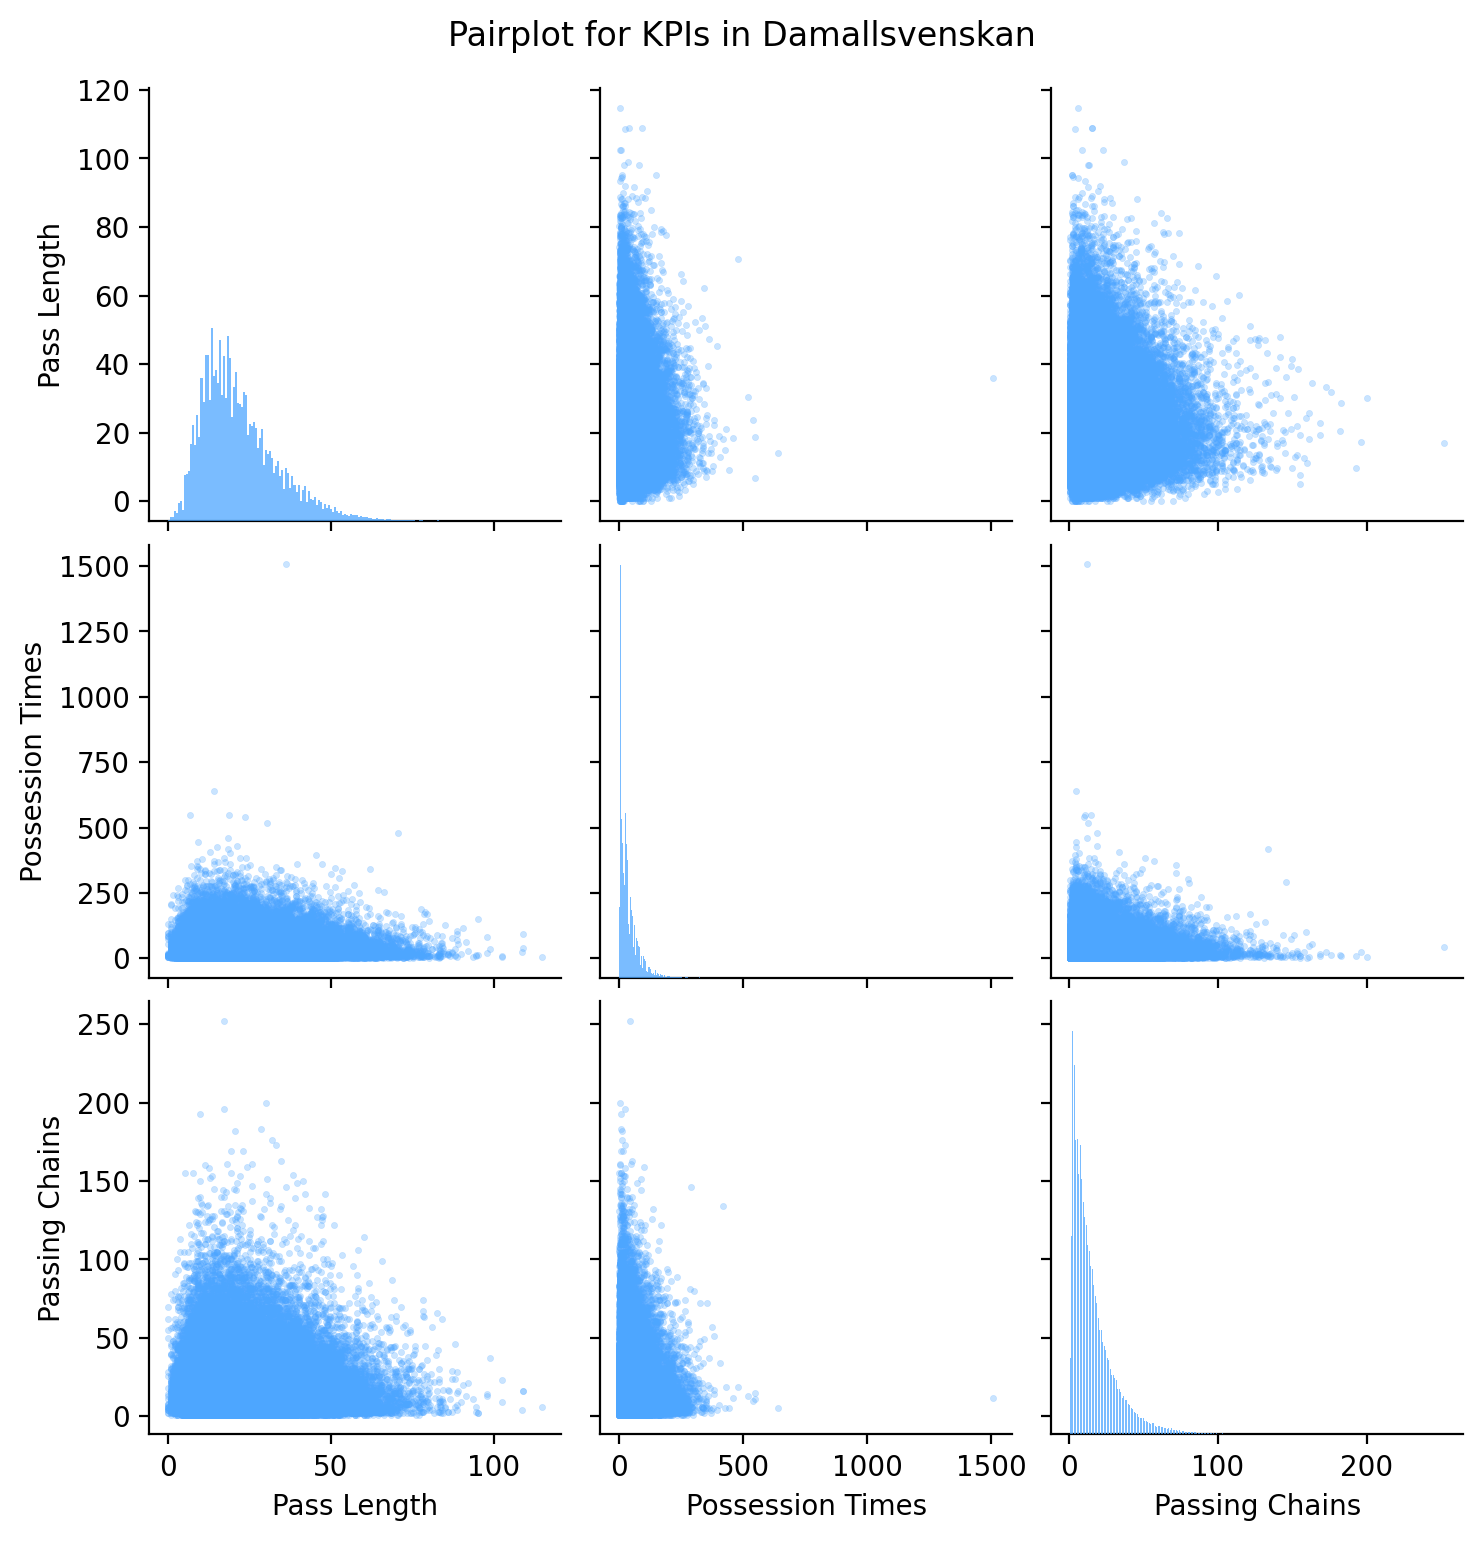

In [21]:
# Correlation matrix between passing length, possession times, and passing chains
pass_length_damallsvenskan = pass_length_damallsvenskan[:len(possession_times_damallsvenskan)]
passing_chains_damallsvenskan = passing_chains_damallsvenskan[:len(possession_times_damallsvenskan)]

import seaborn as sns
import matplotlib.pyplot as plt
# Set the figure dpi
plt.figure(dpi=300)

# Create a DataFrame
df = pd.DataFrame({'Pass Length': pass_length_damallsvenskan, 'Possession Times': possession_times_damallsvenskan, 'Passing Chains': passing_chains_damallsvenskan})

sns.pairplot(df, plot_kws={'color': '#4da6ff', 's': 5, 'alpha': 0.3, 'edgecolor': None}, diag_kws={'color': '#4da6ff', 'edgecolor': None})
plt.suptitle('Pairplot for KPIs in Damallsvenskan', y=1.02)

Text(0.5, 1.02, 'Pairplot for KPIs in Allsvenskan')

<Figure size 1920x1440 with 0 Axes>

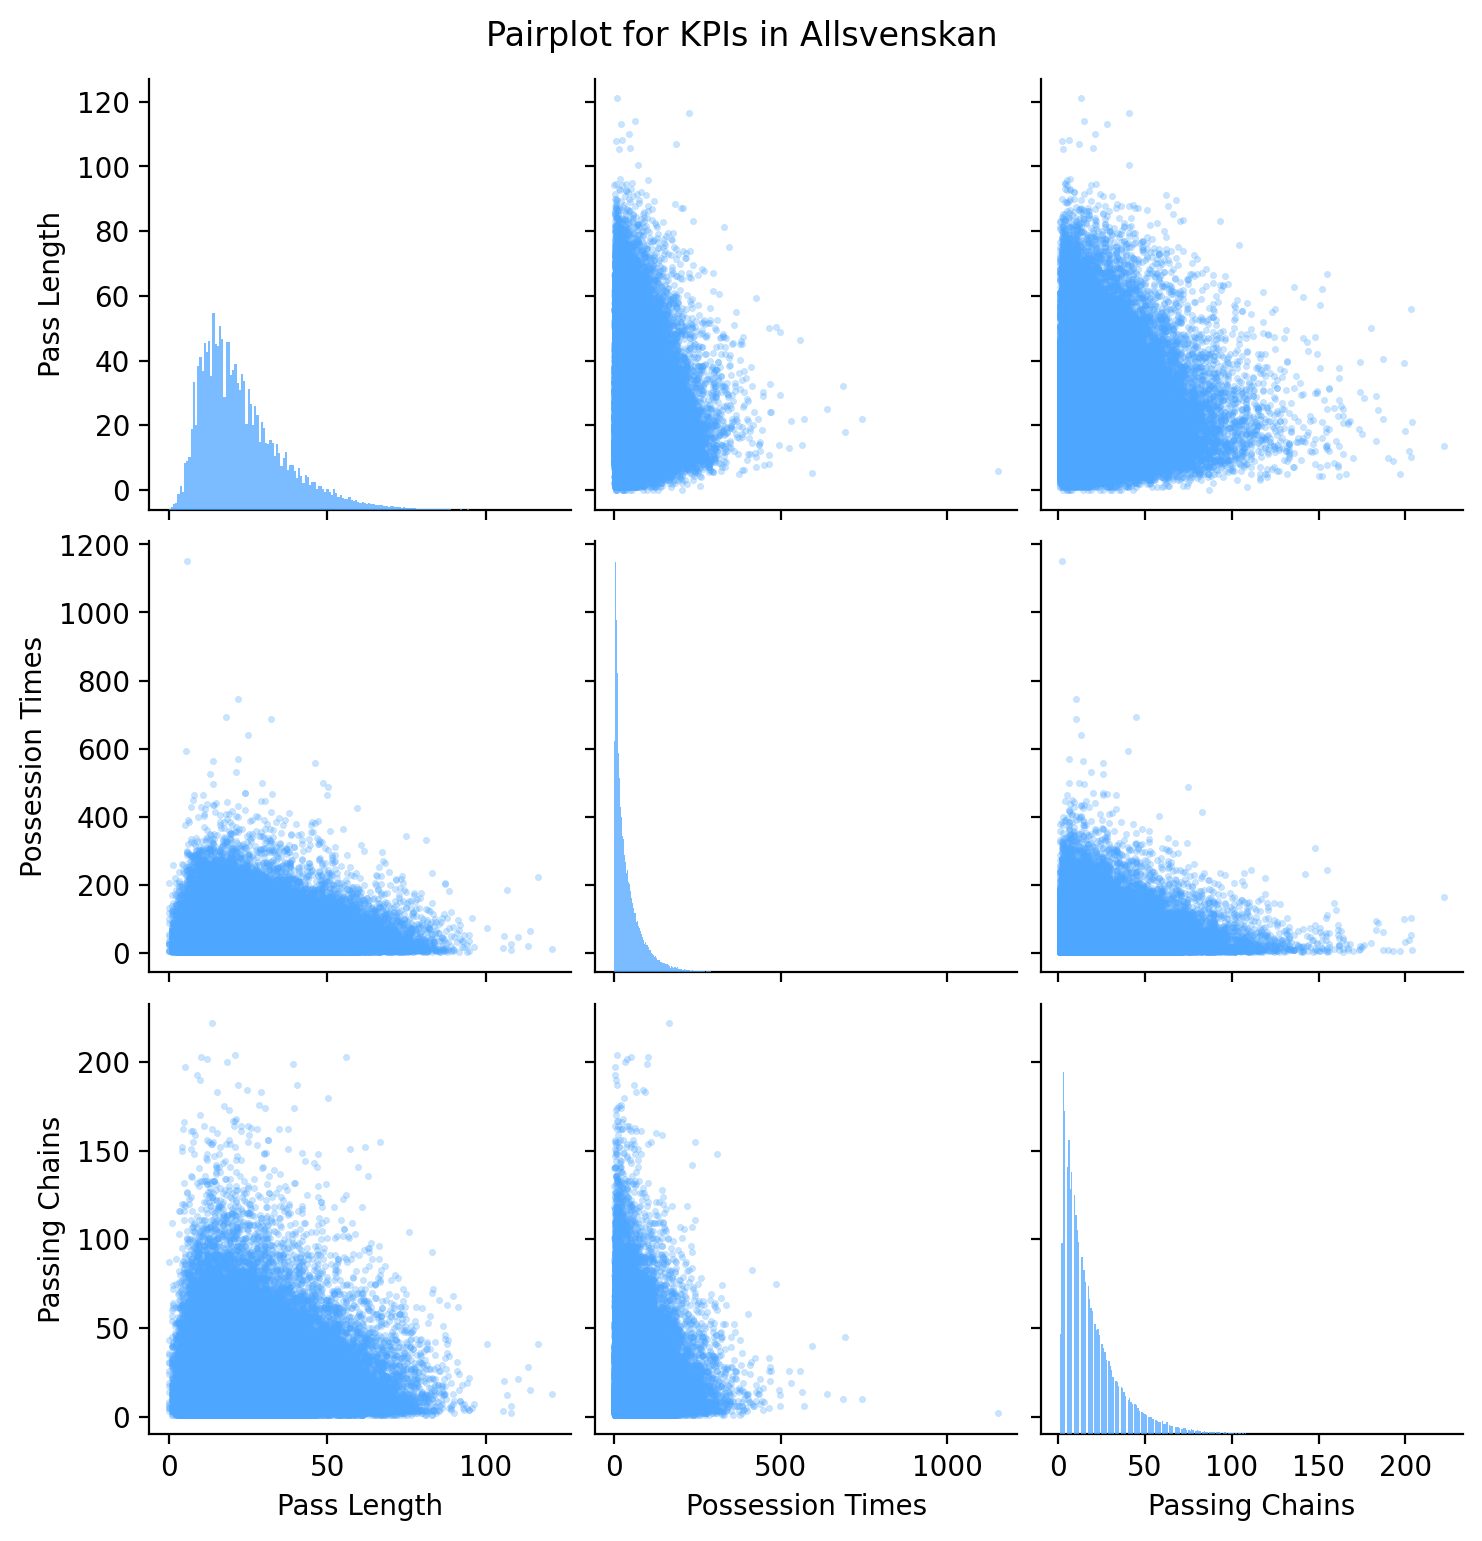

In [22]:
# the same for allsvenskan
pass_length_allsvenskan = pass_length_allsvenskan[:len(possession_times_allsvenskan)]
passing_chains_allsvenskan = passing_chains_allsvenskan[:len(possession_times_allsvenskan)]
#4da6ff
# Create a DataFrame
df = pd.DataFrame({'Pass Length': pass_length_allsvenskan, 'Possession Times': possession_times_allsvenskan, 'Passing Chains': passing_chains_allsvenskan})

# Set the figure dpi
plt.figure(dpi=300)

# Create a DataFrame
df = pd.DataFrame({'Pass Length': pass_length_allsvenskan, 'Possession Times': possession_times_allsvenskan, 'Passing Chains': passing_chains_allsvenskan})

# Create the pairplot
sns.pairplot(df, plot_kws={'color': '#4da6ff', 's': 5, 'alpha': 0.3, 'edgecolor': None}, diag_kws={'color': '#4da6ff', 'edgecolor': None})
plt.suptitle('Pairplot for KPIs in Allsvenskan', y=1.02)